<div align="center">

# Instituto Tecnológico y de Estudios Superiores de Monterrey

**Septiembre–Diciembre 2025**
**Maestría en Inteligencia Artificial Aplicada**

## Avance 2

**Ingeniería de Características**

---

### Equipo académico

|                  | **Nombre**                            |
| ---------------- | ------------------------------------- |
| Profesor Titular | Dra. Grettel Barceló Alonso           |
| Asesora          | Dra. Ludivina Facundo Flores          |
| Tutor            | Mtra. Verónica Sandra Guzmán de Valle |
| Sponsor          | Dr. Jesús Arturo Pérez Díaz           |

---

### Proyecto Integrador

**TC5035.10**

---

### Integrantes

| **Nombre**                        | **Matrícula** |
| --------------------------------- | ------------- |
| Christopher Adolfo Orduña De León | A01795372     |
| Miguel Ángel Paredes Gutiérrez    | A01794138     |
| Carlos Mariano Ramírez Amaya      | A01795036     |

**Fecha:** 5 de Octubre del 2025

</div>


Importar librerías y define configuración.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances

Imprimir resumen del dataframe

In [2]:
PATH = '/Users/carlosmramirez/Documents/MNA/Proyecto_Integrador/Datos/ChinaTelecom_Abril_08_2010/chinatelecom_april_08_2010_all_collectors_ipv4.parquet'

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))
display(df.head(5))

Shape:  (326208, 14)
Columnas: ['as_path', 'collector', 'communities', 'formatted_time', 'local_pref', 'med', 'next_hop', 'origin', 'peer_asn', 'peer_ip', 'prefix', 'project', 'time', 'type']


,as_path,collector,communities,formatted_time,local_pref,med,next_hop,origin,peer_asn,peer_ip,prefix,project,time,type
0,2914 3549 9304 7643 45899,route-views.eqix,"[2914:2000, 65504:3549, 2914:3000, 2914:420]",2010-04-08 17:50:32,None,None,206.223.115.12,None,2914,206.223.115.12,113.190.160.0/19,routeviews,1.270749e+09,A
1,2914 3549 10318 28052,route-views.eqix,"[2914:2000, 65504:3549, 2914:3000, 2914:420]",2010-04-08 17:50:32,None,None,206.223.115.12,None,2914,206.223.115.12,200.11.29.0/24,routeviews,1.270749e+09,A
2,2914 3549 27065 5839,route-views.eqix,"[2914:2000, 65504:3549, 2914:3000, 2914:420]",2010-04-08 17:50:32,None,None,206.223.115.12,None,2914,206.223.115.12,205.97.228.0/22,routeviews,1.270749e+09,A
3,4436 4739 17920,route-views.eqix,[4436:31718],2010-04-08 17:50:32,None,None,206.223.115.60,None,4436,206.223.115.60,113.192.56.0/21,routeviews,1.270749e+09,A
4,4436 4739 17920,route-views.eqix,[4436:31718],2010-04-08 17:50:32,None,None,206.223.115.60,None,4436,206.223.115.60,203.145.62.0/23,routeviews,1.270749e+09,A


In [3]:
df_clean = df.drop(columns=['formatted_time','local_pref','collector','project','med','next_hop','peer_asn','peer_ip','communities'])
df_clean = df_clean[['time','prefix','origin','type','as_path']]
display(df_clean.head(5))

,time,prefix,origin,type,as_path
0,1.270749e+09,113.190.160.0/19,None,A,2914 3549 9304 7643 45899
1,1.270749e+09,200.11.29.0/24,None,A,2914 3549 10318 28052
2,1.270749e+09,205.97.228.0/22,None,A,2914 3549 27065 5839
3,1.270749e+09,113.192.56.0/21,None,A,4436 4739 17920
4,1.270749e+09,203.145.62.0/23,None,A,4436 4739 17920


Ejecucón pasos auxiliares o utilitarios.

In [4]:
clean_file_path = '/Users/carlosmramirez/Documents/MNA/Proyecto_Integrador/Datos/ChinaTelecom_Abril_08_2010/chinatelecom_april_08_2010_clean.parquet'

df_clean.to_parquet(clean_file_path, engine="pyarrow")

## Feature Engineering

In [5]:
clean_file_path = '/Users/carlosmramirez/Documents/MNA/Proyecto_Integrador/Datos/ChinaTelecom_Abril_08_2010/chinatelecom_april_08_2010_clean.parquet'

df_clean = pd.read_parquet(clean_file_path, engine="pyarrow")
print("Shape: ", df_clean.shape)
print("Columnas:", list(df_clean.columns))
display(df_clean.head(5))

Shape:  (326208, 5)
Columnas: ['time', 'prefix', 'origin', 'type', 'as_path']


,time,prefix,origin,type,as_path
0,1.270749e+09,113.190.160.0/19,None,A,2914 3549 9304 7643 45899
1,1.270749e+09,200.11.29.0/24,None,A,2914 3549 10318 28052
2,1.270749e+09,205.97.228.0/22,None,A,2914 3549 27065 5839
3,1.270749e+09,113.192.56.0/21,None,A,4436 4739 17920
4,1.270749e+09,203.145.62.0/23,None,A,4436 4739 17920


### Obtener el `origin` a partir del `as_path`

Se obtuvo el AS de origen desde la secuencia as_path, considerando que el último número en dicha secuencia representa el sistema autónomo que originó el anuncio del prefijo. Este dato es fundamental para evaluar la consistencia de los anuncios BGP, ya que un cambio inesperado en el origin AS puede señalar errores de propagación o comportamientos anómalos, como un posible secuestro de rutas.

Resultados en el notebook.

In [6]:
df_clean.loc[:, 'origin'] = (
    df_clean['as_path']
    .where(df_clean["as_path"].notna(), None)
    .apply(lambda x: str(x).split()[-1])
    )
display(df_clean.head(5))

,time,prefix,origin,type,as_path
0,1.270749e+09,113.190.160.0/19,45899,A,2914 3549 9304 7643 45899
1,1.270749e+09,200.11.29.0/24,28052,A,2914 3549 10318 28052
2,1.270749e+09,205.97.228.0/22,5839,A,2914 3549 27065 5839
3,1.270749e+09,113.192.56.0/21,17920,A,4436 4739 17920
4,1.270749e+09,203.145.62.0/23,17920,A,4436 4739 17920


### Calcular la longitud del `as_path`

Se calculó la longitud del `as_path` con el propósito de analizar la evolución de la ruta a lo largo del tiempo. Cambios significativos en la longitud pueden reflejar modificaciones en la topología de propagación o indicar posibles anomalías en el enrutamiento, como un evento de secuestro de rutas BGP, en el que el tráfico es desviado a través de un número inusual de sistemas autónomos.

Mostrar resultados en el notebook.

In [7]:
df_clean.loc[:, 'as_path_length'] = (
    df_clean['as_path']
    .where(df_clean["as_path"].notna(), None)
    .apply(lambda x: len(str(x).split()) if isinstance(x, str) and x.strip() else 0)
    )
display(df_clean.head(5))

,time,prefix,origin,type,as_path,as_path_length
0,1.270749e+09,113.190.160.0/19,45899,A,2914 3549 9304 7643 45899,5
1,1.270749e+09,200.11.29.0/24,28052,A,2914 3549 10318 28052,4
2,1.270749e+09,205.97.228.0/22,5839,A,2914 3549 27065 5839,4
3,1.270749e+09,113.192.56.0/21,17920,A,4436 4739 17920,3
4,1.270749e+09,203.145.62.0/23,17920,A,4436 4739 17920,3


Limpiar o imputar valores faltantes; Genera gráficos con Matplotlib; Construye o transforma *DataFrames*.

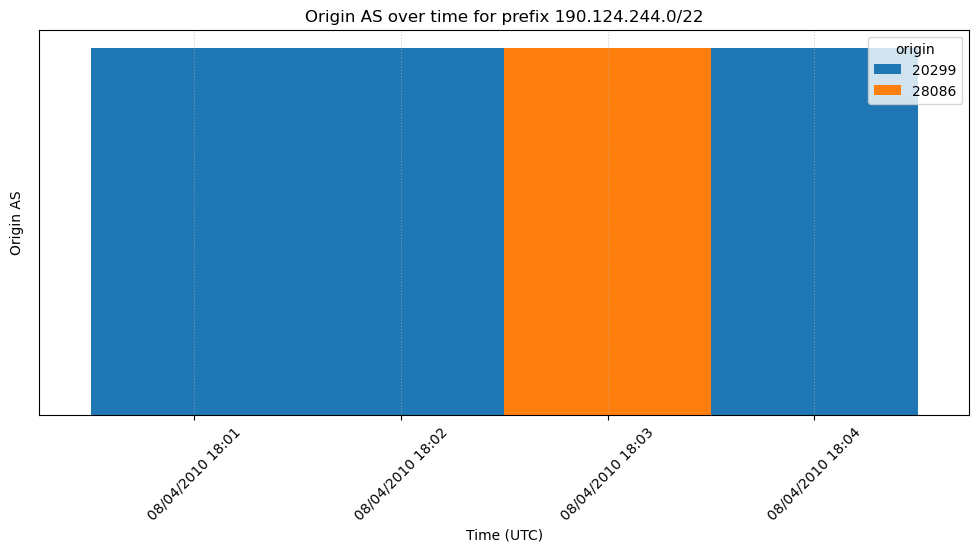

In [8]:
df = df_clean.copy()
df['formatted_time'] = pd.to_datetime(df['time'], unit='s', utc=True, errors='coerce')

target_prefix = '190.124.244.0/22'

df_target = df[(df['prefix'] == target_prefix) & (df['type'] == 'A')].sort_values('formatted_time')

freq = '1min'

df_target = df_target.set_index('formatted_time').resample(freq)['origin'].last().dropna().reset_index()

df_counts = df_target.groupby([pd.Grouper(key='formatted_time', freq=freq), 'origin']).size().unstack(fill_value=0)

ax = df_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12,5),
# Colormap='tab10',
    width=1.0
)

plt.title(f'Origin AS over time for prefix {target_prefix}', fontsize=12)
plt.xlabel('Time (UTC)')
plt.ylabel('Origin AS')
ax.set(yticklabels=[])
ax.tick_params(left=False)
plt.xticks(ticks=range(0, len(df_counts), max(1, len(df_counts)//10)),
           labels=[d.strftime('%d/%m/%Y %H:%M') for d in df_counts.index[::max(1, len(df_counts)//10)]],
           rotation=45)
plt.grid(True, axis='x', linestyle=':', alpha=0.6)

plt.show()

### Cálculo de tiempo entre anuncios por prefijos

Se determinó el intervalo de tiempo entre anuncios del mismo prefijo con el fin de identificar patrones de comportamiento anómalos. Un aumento en la frecuencia de anuncios puede reflejar inestabilidad de la red o intentos de reasignación ilegítima de rutas, lo que resulta útil para correlacionar estos eventos con posibles secuestros de ruta.

Transforma *DataFrames*; Mostrar resultados.

In [9]:
# Orden clave para todos los cálculos
df_clean = df_clean.sort_values(['prefix', 'time']).reset_index(drop=True)

df_clean['secs_between_announcements'] = np.nan

maskA = df_clean['type'].eq('A')
df_clean.loc[maskA, 'secs_between_announcements'] = (
    df_clean[maskA]
      .groupby('prefix')['time']
      .diff()     # como 'time' está en segundos, el diff queda en segundos
)
display(df_clean.head(5))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0


### Cálculo de `AS` únicos en los `as_path`

Se calculó la cantidad de sistemas autónomos únicos presentes en el `as_path` con el propósito de analizar la estructura y consistencia de las rutas. En conjunto con la longitud del camino, esta métrica permite identificar repeticiones o bucles (loops) dentro de la secuencia de `AS`, los cuales son comportamientos inusuales que pueden reflejar errores de propagación o posibles anomalías en el enrutamiento.

**Descripción:** Muestra resultados en el notebook.

In [10]:
def count_unique_as(path: str) -> int:
  if path:
    toks = [t for t in path.split()]
  else:
    toks = []
  return len(set(toks))

df_clean['unique_as_in_path'] = df_clean['as_path'].apply(count_unique_as)

display(df_clean.head(10))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6
5,1.270750e+09,109.109.208.0/20,None,W,None,0,NaN,0
6,1.270750e+09,109.109.208.0/20,21332,A,9002 20485 21332,3,0.0,3
7,1.270750e+09,109.109.208.0/20,21332,A,4826 3356 6854 21332,4,1.0,4
8,1.270750e+09,109.109.208.0/20,21332,A,7018 3549 12389 21332,4,0.0,4
9,1.270750e+09,109.109.208.0/20,21332,A,3257 1299 20485 21332,4,2.0,4


### Cálculo de diferencia entre longitud de `as_path`

Se midió la diferencia entre las longitudes del `as_path` en anuncios consecutivos para observar si la ruta se acorta o se alarga con el tiempo. Variaciones significativas pueden evidenciar cambios en la propagación del prefijo o incluso estar asociadas a secuestros de ruta, donde las rutas legítimas son reemplazadas temporalmente por caminos alternos.

Transformar *DataFrames*

In [11]:
df_clean['as_path_length_diff_A'] = np.nan
maskA = df_clean['type'].eq('A')

df_clean.loc[maskA, 'as_path_length_diff_A'] = (
    df_clean[maskA]
      .groupby('prefix')['as_path_length']
      .diff()
)

df_clean['as_path_length_diff_A_abs'] = df_clean['as_path_length_diff_A']

display(df_clean.head(10))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6,NaN,NaN
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4,NaN,NaN
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4,NaN,NaN
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6,2.0,2.0
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6,-4.0,-4.0
5,1.270750e+09,109.109.208.0/20,None,W,None,0,NaN,0,NaN,NaN
6,1.270750e+09,109.109.208.0/20,21332,A,9002 20485 21332,3,0.0,3,-3.0,-3.0
7,1.270750e+09,109.109.208.0/20,21332,A,4826 3356 6854 21332,4,1.0,4,1.0,1.0
8,1.270750e+09,109.109.208.0/20,21332,A,7018 3549 12389 21332,4,0.0,4,0.0,0.0
9,1.270750e+09,109.109.208.0/20,21332,A,3257 1299 20485 21332,4,2.0,4,0.0,0.0


### Cálculo de MOAS (Multiple Origin AS)

Se añadió una columna que permite identificar los prefijos anunciados por más de un sistema autónomo de origen. Este análisis busca reconocer casos de `Multiple Origin AS (MOAS)`, una situación en la que el mismo prefijo es propagado por distintos AS al mismo tiempo, lo que puede indicar inconsistencias de enrutamiento o incluso secuestros de rutas.

In [12]:
moas_counts = (
    df_clean.groupby(['prefix', 'time'])['origin']
      .nunique()
      .rename('origin_at_time_nuniq')
      .reset_index()
)

df_clean = df_clean.merge(moas_counts, on=['prefix', 'time'], how='left')
df_clean['MOAS'] = (df_clean['origin_at_time_nuniq'] > 1).astype(int)

display(df_clean.head(10))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6,NaN,NaN,1,0
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4,NaN,NaN,1,0
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4,NaN,NaN,1,0
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6,2.0,2.0,2,1
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6,-4.0,-4.0,2,1
5,1.270750e+09,109.109.208.0/20,None,W,None,0,NaN,0,NaN,NaN,2,1
6,1.270750e+09,109.109.208.0/20,21332,A,9002 20485 21332,3,0.0,3,-3.0,-3.0,2,1
7,1.270750e+09,109.109.208.0/20,21332,A,4826 3356 6854 21332,4,1.0,4,1.0,1.0,1,0
8,1.270750e+09,109.109.208.0/20,21332,A,7018 3549 12389 21332,4,0.0,4,0.0,0.0,1,0
9,1.270750e+09,109.109.208.0/20,21332,A,3257 1299 20485 21332,4,2.0,4,0.0,0.0,1,0


### Generar embeddings de los `as_path` para poder interpretarlos

Se generaron embeddings vectoriales a partir de las secuencias del `as_path` con el propósito de representar las rutas BGP en un espacio semántico que capture similitudes estructurales entre ellas. Esta representación permite medir la distancia o diferencia entre rutas consecutivas y detectar cambios significativos en la topología de propagación, los cuales pueden ser indicativos de secuestros de ruta.

**Descripción:** Ejecuta pasos auxiliares o utilitarios.

In [13]:
EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

In [14]:
mask_valid = df_clean['as_path'].notna() & (df_clean['as_path'].astype(str).str.lower() != 'none') & (df_clean['as_path'].astype(str).str.strip() != '')

# Inicializamos una columna vacía
df_clean['as_path_embedding'] = None

# Genera los embeddings solo a las filas válidas
valid_texts = df_clean.loc[mask_valid, 'as_path'].astype(str).tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

Batches:   0%|          | 0/8766 [00:00<?, ?it/s]

In [15]:
for i, idx in enumerate(df_clean.index[mask_valid]):
  df_clean.at[idx, 'as_path_embedding'] = embeddings[i]

display(df_clean.head(10))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6,NaN,NaN,1,0,"[-0.039181516, -0.023284454, -0.1123902, 0.052..."
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4,NaN,NaN,1,0,"[-0.09213455, -0.031599708, -0.095572144, 0.00..."
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4,NaN,NaN,1,0,"[0.06650424, -0.051212523, -0.035398476, -0.04..."
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6,2.0,2.0,2,1,"[-0.052564166, 0.02677035, -0.105090044, -0.00..."
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6,-4.0,-4.0,2,1,"[-0.09425278, 0.045285296, -0.09542984, -0.022..."
5,1.270750e+09,109.109.208.0/20,None,W,None,0,NaN,0,NaN,NaN,2,1,None
6,1.270750e+09,109.109.208.0/20,21332,A,9002 20485 21332,3,0.0,3,-3.0,-3.0,2,1,"[-0.045414593, 0.0058971494, -0.05980574, -0.0..."
7,1.270750e+09,109.109.208.0/20,21332,A,4826 3356 6854 21332,4,1.0,4,1.0,1.0,1,0,"[-0.106040135, -0.07494715, -0.07099203, 0.054..."
8,1.270750e+09,109.109.208.0/20,21332,A,7018 3549 12389 21332,4,0.0,4,0.0,0.0,1,0,"[-0.044437096, -0.013039631, -0.03825444, 0.00..."
9,1.270750e+09,109.109.208.0/20,21332,A,3257 1299 20485 21332,4,2.0,4,0.0,0.0,1,0,"[-0.06701016, -0.058104187, -0.027217759, -0.0..."


### Obtener la distancia de cosenos entre los `as_path`

Se aplicó la distancia de coseno (rango de 0 a 1) sobre los embeddings de las rutas para medir cuán diferentes son dos caminos consecutivos en términos semánticos. Este enfoque da mayor relevancia a los cambios significativos (valor cercano a 1 indica una diferencia) en la estructura de las rutas, lo que facilita que el modelo aprenda a distinguir comportamientos normales de posibles anomalías o secuestros de rutas.

In [16]:
# Solo anuncios (type = 'A')
maskA = df_clean['type'].eq('A')

# Obtener el embedding anterior del mismo prefijo
df_clean.loc[maskA, 'prev_embedding'] = (
    df_clean.loc[maskA]
      .sort_values(['prefix', 'time'])
      .groupby('prefix')['as_path_embedding']
      .shift()
)

# Función para calcular cosine distance
def cos_distance(u, v):
    if isinstance(u, np.ndarray) and isinstance(v, np.ndarray):
# MiniLM devuelve embeddings ya normalizados, así que basta el dot product
        return cosine_distances(u.reshape(1, -1), v.reshape(1, -1))[0, 0]
    return np.nan

# Calcular la distancia fila a fila
df_clean['cosine_distance_prev_A'] = [
    cos_distance(u, v) for u, v in zip(df_clean['as_path_embedding'], df_clean['prev_embedding'])
]

# Limpieza: eliminar columna auxiliar
# Df_clean.drop(columns=['prev_embedding'], inplace=True) # No se eliminó para quedar registrado si detectaba un anuncio anterior

display(df_clean.head(10))

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6,NaN,NaN,1,0,"[-0.039181516, -0.023284454, -0.1123902, 0.052...",NaN,NaN
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4,NaN,NaN,1,0,"[-0.09213455, -0.031599708, -0.095572144, 0.00...",NaN,NaN
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4,NaN,NaN,1,0,"[0.06650424, -0.051212523, -0.035398476, -0.04...",NaN,NaN
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6,2.0,2.0,2,1,"[-0.052564166, 0.02677035, -0.105090044, -0.00...","[0.06650424, -0.051212523, -0.035398476, -0.04...",0.343521
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6,-4.0,-4.0,2,1,"[-0.09425278, 0.045285296, -0.09542984, -0.022...","[-0.052564166, 0.02677035, -0.105090044, -0.00...",0.081563
5,1.270750e+09,109.109.208.0/20,None,W,None,0,NaN,0,NaN,NaN,2,1,None,NaN,NaN
6,1.270750e+09,109.109.208.0/20,21332,A,9002 20485 21332,3,0.0,3,-3.0,-3.0,2,1,"[-0.045414593, 0.0058971494, -0.05980574, -0.0...","[-0.09425278, 0.045285296, -0.09542984, -0.022...",0.477419
7,1.270750e+09,109.109.208.0/20,21332,A,4826 3356 6854 21332,4,1.0,4,1.0,1.0,1,0,"[-0.106040135, -0.07494715, -0.07099203, 0.054...","[-0.045414593, 0.0058971494, -0.05980574, -0.0...",0.378733
8,1.270750e+09,109.109.208.0/20,21332,A,7018 3549 12389 21332,4,0.0,4,0.0,0.0,1,0,"[-0.044437096, -0.013039631, -0.03825444, 0.00...","[-0.106040135, -0.07494715, -0.07099203, 0.054...",0.331644
9,1.270750e+09,109.109.208.0/20,21332,A,3257 1299 20485 21332,4,2.0,4,0.0,0.0,1,0,"[-0.06701016, -0.058104187, -0.027217759, -0.0...","[-0.044437096, -0.013039631, -0.03825444, 0.00...",0.309038


## Guardar dataframe final

**Descripción:** Ejecuta pasos auxiliares o utilitarios.

In [17]:
output_file_path = '/Users/carlosmramirez/Documents/MNA/Proyecto_Integrador/Datos/ChinaTelecom_Abril_08_2010/chinatelecom_april_08_2010_output.parquet'

df_clean.to_parquet(output_file_path, engine="pyarrow")

## Conclusiones

En concordancia con la fase de preparación de datos de la metodología **CRISP-ML**, se logró transformar la información **BGP** cruda en un conjunto de datos estructurado, depurado y técnicamente apto para su uso en modelos de aprendizaje automático. Las tareas de limpieza, normalización y enriquecimiento garantizaron la consistencia semántica y temporal de los registros, asegurando que los anuncios, retiros y rutas se integraran de manera coherente.
 
Como parte del proceso de ingeniería de características la cual es núcleo de esta etapa en **CRISP-ML** se generaron variables clave como el `AS` de origen, la longitud del `as_path`, la cantidad de sistemas autónomos `únicos`, los intervalos entre anuncios y la detección de prefijos con múltiples orígenes `MOAS`. Estas características permitieron capturar el comportamiento estructural y temporal del enrutamiento BGP, habilitando una representación más rica y discriminativa.
 
Adicionalmente, la incorporación de embeddings del as_path y el cálculo de distancias de coseno entre anuncios consecutivos permitió representar las rutas en espacios vectoriales capaces de reflejar similitudes semánticas, variaciones estructurales y patrones anómalos. Este enfoque combinó dimensiones operacionales, estadísticas y contextuales, fortaleciendo la base analítica para la detección de eventos irregulares o posibles secuestros de rutas.
 
En conjunto, el resultado de esta fase corresponde a un dataset de alta calidad y relevancia operacional, alineado con los criterios de preparación de **CRISP-ML**. Con ello se establece una base sólida, confiable y representativa que habilita el tránsito a la etapa de modelado, maximizando la capacidad del sistema para detectar anomalías en el enrutamiento **BGP** con precisión y fundamento técnico.